# PINN

We are using ML techniques to solve the problem faster than solving a PDE numerically. However, the presence of a PDE means physics are informed. Thus , using a PINN makes sense.

The model takes physical parameters as input and predicts the meshed field representing the solidification morphology. We used a fully connected physics-informed neural network (PINN) to learn the mapping from parameters to morphology while embedding spatial physical constraints. The network consists of three fully connected layers with Tanh activations, which enable smooth nonlinear transformations aligned with the diffusive nature of the governing equations. The output layer generates a flattened 100×100 field without any activation function, allowing the model to predict continuous field values. A physics-inspired regularization is incorporated by penalizing the Laplacian of the predicted field, promoting spatial smoothness and enforcing diffusion-like behavior in the morphology.

Why only the Laplacian? 
We are predicting the final frame "at equilibrium" so the derivatives with respect to time are 0.
Also, we have no means to compute the source term.

In [ ]:
# Cell 0

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Enable GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Cell 1

# Load the datasets
X_train = np.load('X_train.npy')  # (num_samples, input_dim=5)
Y_train = np.load('Y_train.npy')  # (num_samples, 100, 100)
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(250, 5) (250, 100, 100)
(63, 5) (63, 100, 100)


In [ ]:
# Cell 2

# Remove index 228
X_train = np.delete(X_train, 228, axis=0)
Y_train = np.delete(Y_train, 228, axis=0)

print(X_train.shape, Y_train.shape)

# Flatten Y fields from (100, 100) to (10000,)
Y_train_flat = Y_train.reshape(Y_train.shape[0], -1)
Y_test_flat = Y_test.reshape(Y_test.shape[0], -1)

print(Y_train_flat.shape)
print(Y_test_flat.shape)


(249, 5) (249, 100, 100)
(249, 10000)
(63, 10000)


In [ ]:
# Cell 3
# Network architecture

class PINN(nn.Module):
    def __init__(self, input_dim=5, output_dim=10000):
        super(PINN, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)


In [ ]:
# Cell 4

def physics_loss(predictions):
    """
    Penalize large Laplacians (smoothness + physics-inspired regularization).
    """
    batch_size = predictions.shape[0]
    predictions = predictions.view(batch_size, 100, 100)

    laplacian = (
        -4 * predictions
        + torch.roll(predictions, shifts=1, dims=1)
        + torch.roll(predictions, shifts=-1, dims=1)
        + torch.roll(predictions, shifts=1, dims=2)
        + torch.roll(predictions, shifts=-1, dims=2)
    )
    laplacian = laplacian.view(batch_size, -1)
    loss = torch.mean(laplacian**2)
    return loss


In [ ]:
# Cell 5

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_flat, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_flat, dtype=torch.float32).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

physics_weight = 0.01  # You can tune this


In [ ]:
# Cell 6

num_epochs = 5000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    preds = model(X_train_tensor)
    data_loss = criterion(preds, Y_train_tensor)
    phys_loss = physics_loss(preds)
    loss = data_loss + physics_weight * phys_loss
    
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        test_loss = criterion(test_preds, Y_test_tensor)
    
    train_losses.append(data_loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {data_loss.item():.6f} | Test Loss: {test_loss.item():.6f} | Physics Loss: {phys_loss.item():.6f}")


Epoch 50/5000 | Train Loss: 0.085488 | Test Loss: 0.090251 | Physics Loss: 0.027666
Epoch 100/5000 | Train Loss: 0.080942 | Test Loss: 0.085280 | Physics Loss: 0.008680
Epoch 150/5000 | Train Loss: 0.067390 | Test Loss: 0.070006 | Physics Loss: 0.017056
Epoch 200/5000 | Train Loss: 0.040914 | Test Loss: 0.042462 | Physics Loss: 0.023037
Epoch 250/5000 | Train Loss: 0.036233 | Test Loss: 0.038554 | Physics Loss: 0.007410
Epoch 300/5000 | Train Loss: 0.035199 | Test Loss: 0.037603 | Physics Loss: 0.005723
Epoch 350/5000 | Train Loss: 0.034148 | Test Loss: 0.036852 | Physics Loss: 0.006307
Epoch 400/5000 | Train Loss: 0.033050 | Test Loss: 0.036122 | Physics Loss: 0.006430
Epoch 450/5000 | Train Loss: 0.032010 | Test Loss: 0.035378 | Physics Loss: 0.005814
Epoch 500/5000 | Train Loss: 0.030974 | Test Loss: 0.034539 | Physics Loss: 0.005252
Epoch 550/5000 | Train Loss: 0.029690 | Test Loss: 0.033344 | Physics Loss: 0.004894
Epoch 600/5000 | Train Loss: 0.028223 | Test Loss: 0.031905 | Phys

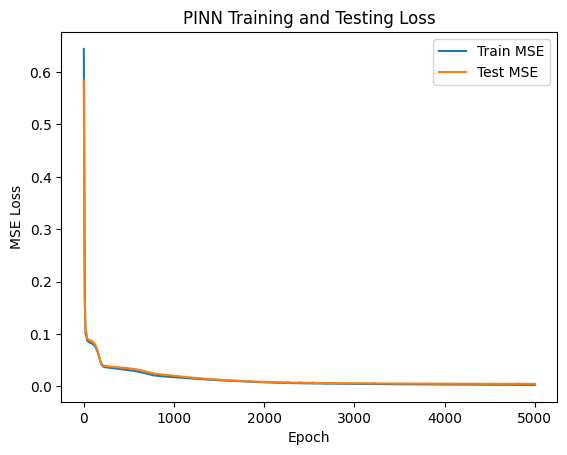

In [ ]:
# Cell 7

plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('PINN Training and Testing Loss')
plt.show()


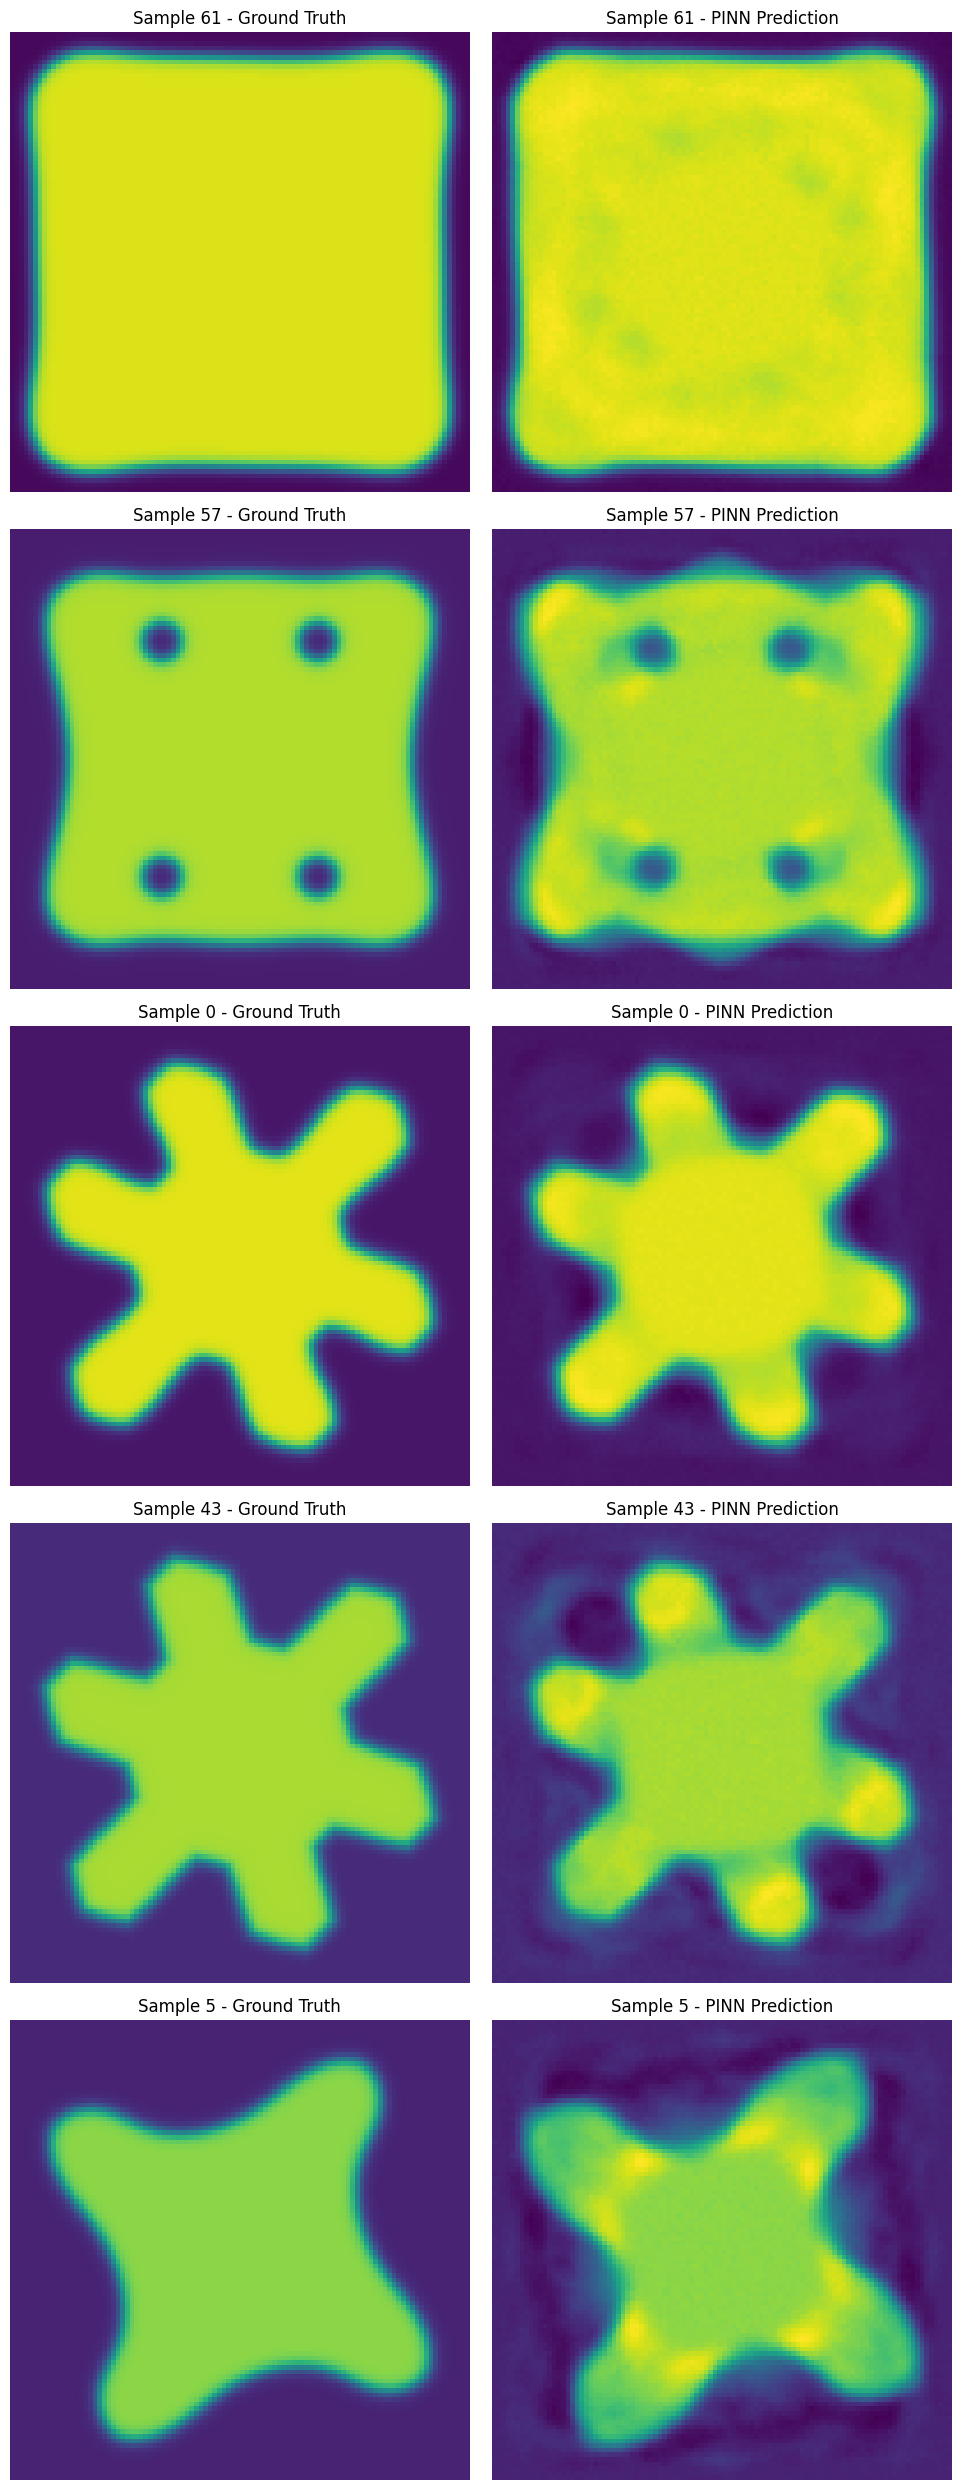

In [ ]:
# Cell 8

def plot_multiple_comparisons(indices):
    model.eval()
    fig, axs = plt.subplots(len(indices), 2, figsize=(10, 5 * len(indices)))

    for idx, sample_idx in enumerate(indices):
        with torch.no_grad():
            input_sample = X_test_tensor[sample_idx:sample_idx+1]
            pred = model(input_sample).cpu().numpy().reshape(100, 100)
            true = Y_test_tensor[sample_idx].cpu().numpy().reshape(100, 100)

        vmin = min(pred.min(), true.min())
        vmax = max(pred.max(), true.max())

        axs[idx, 0].imshow(true, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 0].set_title(f'Sample {sample_idx} - Ground Truth')
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(pred, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 1].set_title(f'Sample {sample_idx} - PINN Prediction')
        axs[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

random_indices = np.random.choice(len(X_test), size=5, replace=False)
plot_multiple_comparisons(random_indices)


Output is decent enough